In [1]:
#%matplotlib notebook
%matplotlib inline
import sys
sys.path.append("..")
import matplotlib.pyplot as plt
import torch.nn as nn
import os
import numpy as np
import json
import argparse
import torch
from torch.optim import lr_scheduler
from tqdm import tqdm
from data_loader import data_loaders as module_data
from model import loss as module_loss
from model import metric as module_metric
from model import model as module_arch
from trainer import Trainer
from utils import Logger
from utils import util
from utils import torchsummary
from utils import viewTraining
from utils import lr_finder
from utils import classActivationMap
import importlib
import math
import torchvision
from torch.nn import functional as F
from torch import topk
import skimage.transform
import jupyter
from IPython import display
from ipywidgets import *
print("Modules loaded")

importlib.reload(module_data) #load recent changes to data_loaders.py
importlib.reload(module_arch)
importlib.reload(module_loss)
importlib.reload(module_metric)
importlib.reload(util)
importlib.reload(viewTraining)
importlib.reload(lr_finder)
importlib.reload(classActivationMap)
print("Reload complete")

print("GPUs available: " + str(torch.cuda.device_count()))
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"




C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\tqdm\autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


Modules loaded
Reload complete
GPUs available: 1


In [2]:
#This function gets the parameters from the config.json file 
def get_instance(module, name, config, *args):
    return getattr(module, config[name]['type'])(*args, **config[name]['args'])


config_file = 'C:/Users/awoloshu/Documents/NephNet/saved/train33test44/1230_153617/config.json'
saved_dir = 'C:/Users/awoloshu/Documents/NephNet/saved/train33test44/1230_153617/'
config_saved_filename = os.path.join(saved_dir, "config.json")
resume = os.path.join(saved_dir, "model_best.pth")



# load config file
with open(config_file) as handle:
    config = json.load(handle)
# setting path to save trained models and log files
path = os.path.join(config['trainer']['save_dir'], config['name'])

Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


Total number of training images = 63524


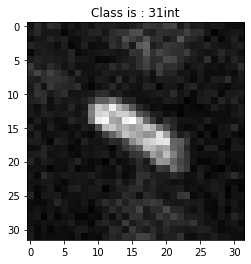

interactive(children=(IntSlider(value=0, description='layer', max=6), Output()), _dom_classes=('widget-interac…

In [3]:



data_loader = getattr(module_data, config['data_loader_test']['type'])(
    "C:/Users/awoloshu/Desktop/datasets/Train33test44/3d_all/44/dataset.h5",
    batch_size=1,
    shuffle=True,
    validation_split=0.0,
    training=False,
    num_workers=0,
    mean = 14.62,
    stdev = 18.11)
print("Total number of training images = " + str(data_loader.dataset.data_len))
valid_data_loader = data_loader.split_validation() #allocate some images as validation

normalized = False
util.visualizeBatch(data_loader, normalized) 

In [4]:
model = get_instance(module_arch, 'arch', config)
print(model)
# get function handles of loss and metrics
loss_fn = getattr(module_loss, config['loss'])
criterion = loss_fn(None)
metric_fns = [getattr(module_metric, met) for met in config['metrics']]

# load state dict
checkpoint = torch.load(resume)
state_dict = checkpoint['state_dict'] #dictionary of model parameters from saved file
if config['n_gpu'] > 1:
    model = torch.nn.DataParallel(model)
model.load_state_dict(state_dict) 

# prepare model for testing
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval() #tells model to ignore dropout and batch normalization

total_loss = 0.0
total_metrics = torch.zeros(len(metric_fns))

classes = ('s1', 's2', 'TAL' ,'DCT', 'CD', 'CD45', 'nestin', 'cd31glom', 'cd31int')
all_pred = []
all_true = []
hm_layers = {'final_layer': 'conv_layer4', 'fc_layer': 'fc7', 'conv_num': 2, 'fc_num': 0}








threeDmodel(
  (conv_layer1): Sequential(
    (0): Conv3d(1, 76, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(76, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv3d(76, 76, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(76, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv3d(76, 152, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(152, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv3d(152, 152, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(152, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): 

In [5]:
%matplotlib inline
from ipywidgets import widgets, interact
def visualizeFilters(filters):
    '''
    Visualize all the filters as an array that can be scrolled through
    '''
    fin, fout, kerz, kery, kerx = filters.shape
    print(filters.shape)
    montage = np.zeros((kerz,int(fin*kery/12), int(fin*kerx/8)))
    print(montage.shape)
    row = 0
    col = 0
    for i, filt in enumerate(filters):
        filt = np.squeeze(filt)
        if col+kerx > montage.shape[1]:
            row+=kerx
            col = 0
        a = montage[:,col:col+kerx, row:row+kerx]
        #print("{} {} {}".format(row, col, i*5))
        montage[:,col:col+kerx, row:row+kerx ] = filt
        col +=kerx
    print("========================================")
    montage = (montage - np.min(np.ravel(montage)))/ ( np.max(np.ravel(montage)) -  np.min(np.ravel(montage)))
    
    def update_layer(layer = 0):
            plt.imshow(montage[layer], cmap ='gray')
            plt.show()
            
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    plt.title("Montage of first convolutional filters")
    plt.imshow(montage[0], cmap ='gray')
    interact(update_layer, layer=widgets.IntSlider(min=0,max=montage.shape[0]-1,step=1,value=0))

   

(96, 1, 5, 5, 5)
(5, 40, 60)


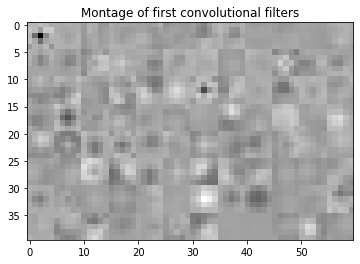

interactive(children=(IntSlider(value=0, description='layer', max=4), Output()), _dom_classes=('widget-interac…

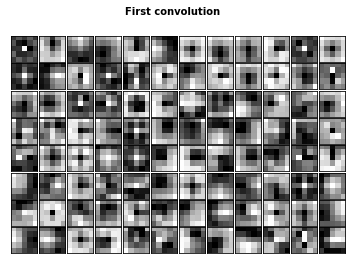

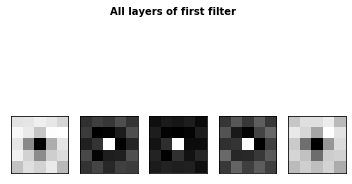

In [36]:
for m in model.modules():
    if isinstance(m, nn.Conv3d):
        fin, fout, kerx, kery, kerz = m.weight.data.cpu().numpy().shape
        if kerx == 5:
            filters = m.weight.data.cpu().numpy()
            visualizeFilters(filters)
            fig, axs = plt.subplots(8, 12,facecolor='w', edgecolor='k')
            plt.suptitle(("First convolution"),
                 fontsize=10, fontweight='bold')
            axs = axs.ravel()
            fig.subplots_adjust(hspace = 0.05, wspace= 0.05)
            for i in range(fin):
                filt = np.squeeze(filters[i])[3]
                axs[i].imshow(filt, cmap = 'gray')
                axs[i].set_xticks([])
                axs[i].set_yticks([])
            plt.show()    
            plt.pause(0.1)
            fig1, axs1 = plt.subplots(1, 5,facecolor='w', edgecolor='k')
            plt.suptitle(("All layers of first filter"),
                 fontsize=10, fontweight='bold')
            axs1 = axs1.ravel()
            fig.subplots_adjust(hspace = 0.05, wspace= 0.05)
            for i in range(5):
                filt = np.squeeze(filters[0])[i]
                axs1[i].imshow(filt, cmap = 'gray')
                axs1[i].set_xticks([])
                axs1[i].set_yticks([])
            plt.show() 
                
        

In [31]:
data_loader = getattr(module_data, config['data_loader_test']['type'])(
    "C:/Users/awoloshu/Desktop/datasets/Train33test44/3d_all/44/dataset.h5",
    batch_size=1,
    shuffle=True,
    validation_split=0.0,
    training=False,
    num_workers=0,
    mean = 14.62,
    stdev = 18.11)
print("data loader created")

data loader created


torch.Size([1, 1, 7, 32, 32])
torch.Size([1])


Text(0.5, 1.0, 'Some image of class cd31int')

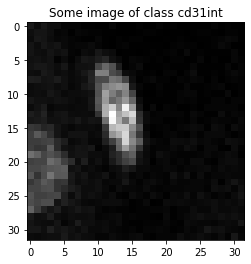

In [32]:
data, label = next(iter(data_loader))
print(data.shape)
print(label.shape)
img = np.squeeze(data[0].numpy())
fig = plt.figure(figsize = (4,4))
plt.imshow(img[2], cmap = 'gray')
plt.title("Some image of class {}".format(classes[int(np.squeeze(label[0].numpy()))]))


In [33]:
#model = model.module
#print(model)
#a = nn.Sequential(model_gp.low_conv, list(*model_gp.low_conv))
modulelist = nn.Sequential(model.conv_layer1, model.conv_layer2, model.conv_layer3, model.conv_layer4)
print(len(modulelist))
print(modulelist[:])


4
Sequential(
  (0): Sequential(
    (0): Conv3d(1, 76, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(76, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv3d(76, 76, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(76, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv3d(76, 152, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(152, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv3d(152, 152, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(152, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_

torch.Size([7, 32, 32])
torch.Size([3, 16, 16])
torch.Size([1, 8, 8])
torch.Size([1, 4, 4])
torch.Size([1, 4, 4])


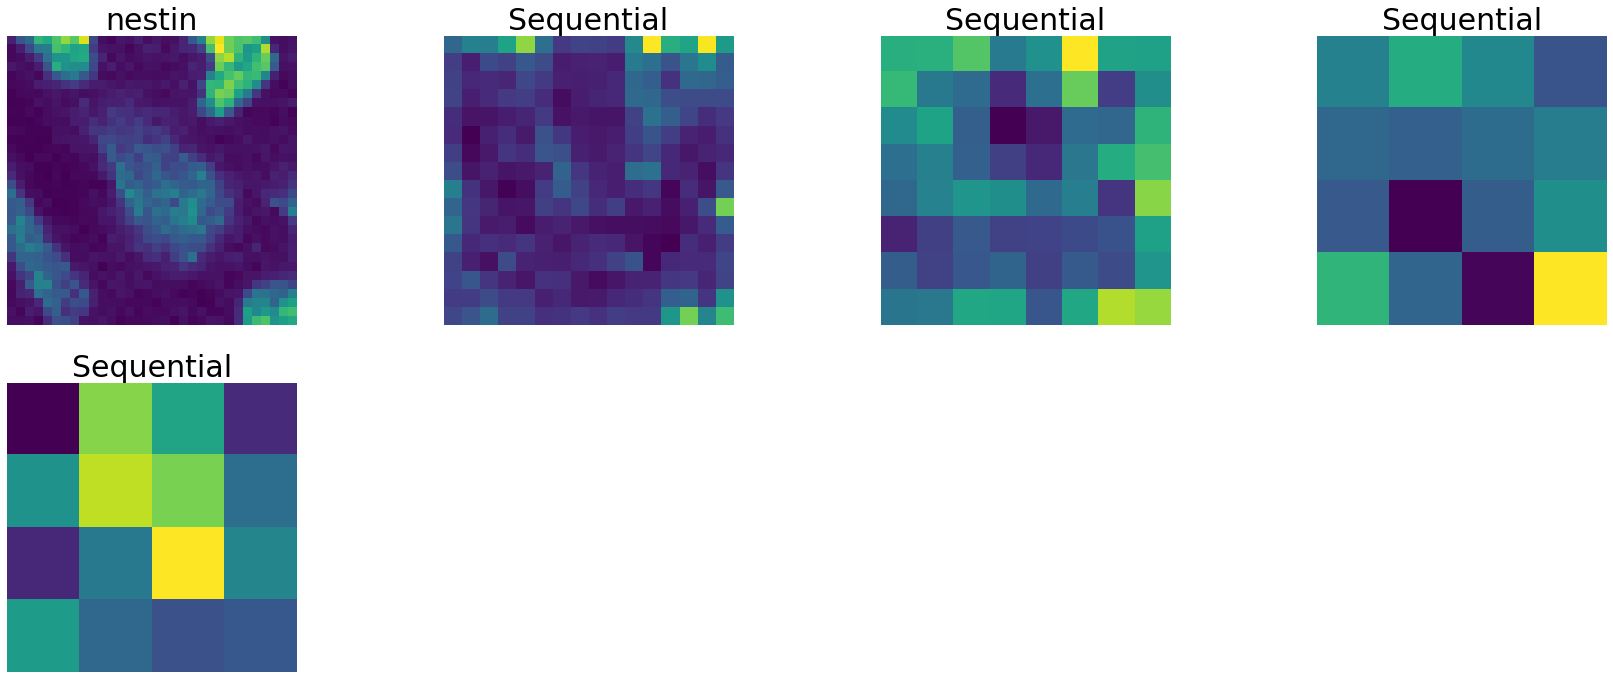

In [34]:
data, label = next(iter(data_loader))
lab = classes[int(np.squeeze(label.numpy()))]
def to_grayscale(image):
    """
    input is (d,w,h)
    converts 3D image tensor to grayscale images corresponding to each channel
    """
    image = torch.sum(image, dim=0)
    image = torch.div(image, image.shape[0])
    return image

def layer_outputs(image):
    outputs = []
    names = []
    outputs.append(image)
    names.append(lab)
    for layer in modulelist[:]:
        image = layer(image)
        outputs.append(image)
        names.append(str(layer))
        
    output_im = []
    for i in outputs:
        i = i.squeeze(0)
        temp = to_grayscale(i)
        print(temp.shape)
        if temp.shape[0] > 1:
            temp = temp[int(temp.shape[0]/2)]
        else:
            temp = temp[0]
        output_im.append(temp.data.cpu().numpy())
        
    fig = plt.figure(figsize = (30, 50))
#    plt.rcParams["figure.figsize"] = (30, 50)


    for i in range(len(output_im)):
        a = fig.add_subplot(8,4,i+1)
        imgplot = plt.imshow(output_im[i])
        plt.axis('off')
        a.set_title(names[i].partition('(')[0], fontsize=30)

    #plt.savefig('layer_outputs.jpg', bbox_inches='tight')
    

layer_outputs(data.cuda())

(76, 3, 16, 16)
(16, 16)


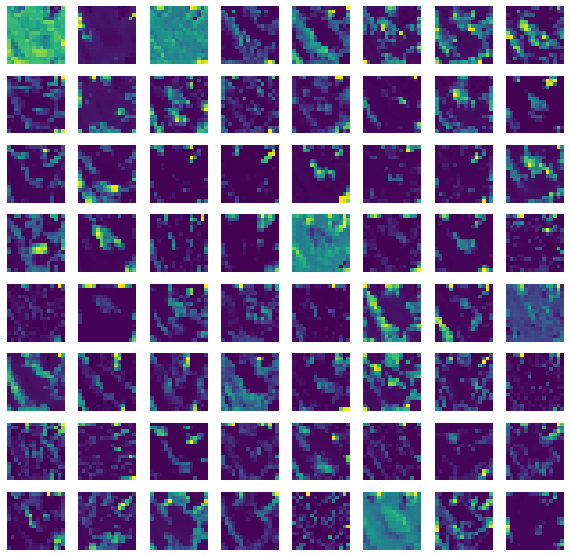

In [35]:
def filter_outputs(image, layer_to_visualize):
    if layer_to_visualize < 0:
        layer_to_visualize += len(modulelist)-1
    output = None
    name = None
    for count, layer in enumerate(modulelist[:]):
        image = layer(image)
        if count == layer_to_visualize: 
            output = image
            name = str(layer)
    
    filters = []
    #output = output.data.squeeze()
    output = output.cpu()
    output = output[0].detach().cpu().numpy()
    print(output.shape)
    for i in range(output.shape[0]):
        if output.shape[1] > 1:
            depth = int(output.shape[1]/2)
            im = output[i,depth,:,:]
        else:
            im = output[i,0,:,:]
        filters.append(im)
        if i == 1: print(filters[0].shape)
        
    fig = plt.figure(figsize = (10,10))
    #plt.rcParams["figure.figsize"] = (10, 10)

    for i in range(int(np.sqrt(len(filters))) * int(np.sqrt(len(filters)))):
        fig.add_subplot(np.sqrt(len(filters)), np.sqrt(len(filters)),i+1)
        imgplot = plt.imshow(filters[i])
        plt.axis('off')
        
filter_outputs(data.cuda(), 0)

C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


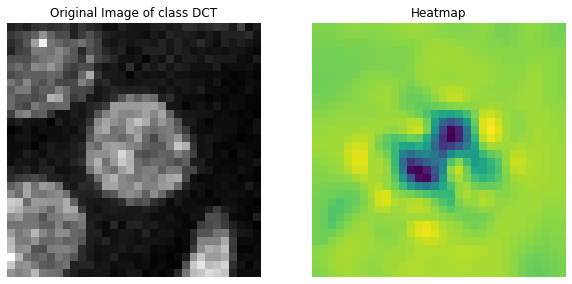

In [46]:
from torch.autograd import Variable
from scipy.ndimage import zoom
def make_heatmap(image, true_class, k=3, stride=3): 
    #print(image.shape)
    """
    Input image is of size (1, c, w, h) typically (1, 3, 224, 224) for vgg16
    true_class is a number corresponding to imagenet classes
    k in the filter size (c, k, k)
    
    
    input image is of size (1, c, d, w, h) typically (1, 1, 7, 32, 32)
    k in the filter size (k,k,k)
    """

    heatmap = torch.zeros(int(((image.shape[2]-k)/stride)+1), 
                          int(((image.shape[3]-k)/stride)+1),
                          int(((image.shape[4]-k)/stride)+1))
    #print(heatmap.shape) #2 10 10 
    image = image.data

    i = 0
    a = 0
    while i<=image.shape[3]-k:
        j = 0 
        b = 0
        while j<=image.shape[2]-k:
            z = 0
            d = 0
            while z<= image.shape[4] - k:
                h_filter = torch.ones(image.shape)
                h_filter[:,:,j:j+k, i:i+k, z:z+k] = 0
                temp_image = Variable((image.cuda() * h_filter.cuda()).cuda())
                temp_softmax = model(temp_image)
                temp_softmax = torch.nn.functional.softmax(temp_softmax).data[0]
                heatmap[b][a][d] = temp_softmax[true_class]
                #print(temp_softmax[true_class])
                
                d+=1
                z+=stride
            j += stride
            b += 1
        #print(a)
        i += stride
        a += 1
    
    image = image.squeeze()
    true_image = image
    #true_image = image.transpose(0,1)
    #true_image = true_image.transpose(1,2)
    # Un-Normalize image
    #true_image = true_image * torch.Tensor([0.229, 0.224, 0.225]).cuda()  + torch.Tensor([0.485, 0.456, 0.406]).cuda()
    true_image = true_image*torch.Tensor([data_loader.stdev]).cuda() + torch.Tensor([data_loader.mean]).cuda()
    true_image = true_image.detach().cpu().numpy()
    
    
    # Plot both images
    fig = plt.figure(figsize  = (10,10))
    #plt.rcParams["figure.figsize"] = (20, 20)
    
    a = fig.add_subplot(1,2,1)
    #MAX PROJECTION
    true_image = np.max(true_image, axis = 0)
    imgplot = plt.imshow(true_image, cmap = 'gray')
    
    #imgplot = plt.imshow(true_image[2], cmap = 'gray')
    plt.title('Original Image of class {}'.format(classes[int(np.squeeze(label.numpy()))]))
    plt.axis('off') 
    
    # Normalize heatmap
    heatmap = heatmap - heatmap.min()
#     heatmap = heatmap/heatmap.max()
    heatmap = np.uint8(255 * heatmap)
    z,x,y = heatmap.shape
    heatmap = zoom(heatmap, (7/z,32/x,32/y))
    a = fig.add_subplot(1,2,2)
    
    #MAX PROJECTION
    heatmap = np.max(heatmap, axis = 0)
    imgplot = plt.imshow(heatmap)
    #imgplot = plt.imshow(heatmap[2])
    plt.title('Heatmap')
    plt.axis('off') 
    
    return heatmap

data, label = next(iter(data_loader))
lab = classes[int(np.squeeze(label.numpy()))]
true_class = int(np.squeeze(label.numpy()))
hm = make_heatmap(data.cuda(), true_class, k=3, stride=3)

for i in range(1):
    continue
    fig = plt.figure(figsize  = (10,10))
    #plt.rcParams["figure.figsize"] = (20, 20)
    
    a = fig.add_subplot(1,2,1)
    image = data.cuda().squeeze()
    true_image = image
    #true_image = image.transpose(0,1)
    #true_image = true_image.transpose(1,2)
    # Un-Normalize image
    #true_image = true_image * torch.Tensor([0.229, 0.224, 0.225]).cuda()  + torch.Tensor([0.485, 0.456, 0.406]).cuda()
    true_image = true_image*torch.Tensor([data_loader.stdev]).cuda() + torch.Tensor([data_loader.mean]).cuda()
    true_image = np.max(true_image.detach().cpu().numpy(), axis = 0)
    imgplot = plt.imshow(true_image, cmap = 'gray')
    plt.title('Original Image of class {}'.format(classes[int(np.squeeze(label.numpy()))]))
    plt.axis('off') 
    
    # Normalize heatmap
    heatmap =hm
    #heatmap = heatmap - heatmap.min()
    heatmap = heatmap/heatmap.max()
    heatmap = np.uint8(255 * heatmap)
    z,x,y = heatmap.shape
    heatmap = zoom(heatmap, (7/z,32/x,32/y))
    heatmap = np.max(heatmap, axis=0)
    a = fig.add_subplot(1,2,2)
    imgplot = plt.imshow(heatmap)
    plt.title('Heatmap')
    plt.axis('off') 

C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


(15, 32, 32)


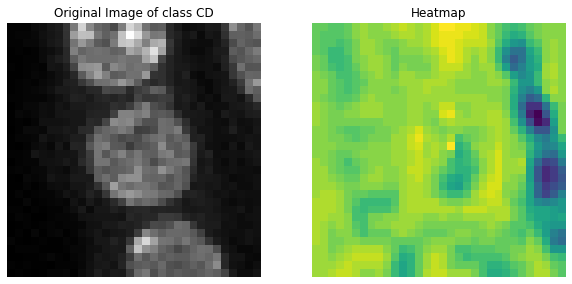

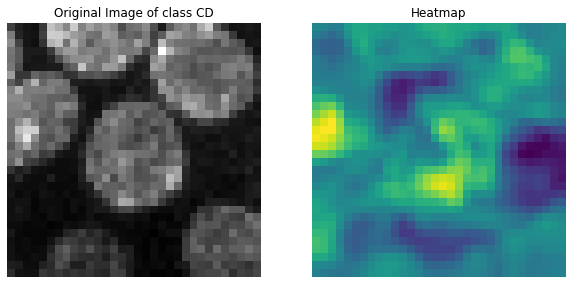

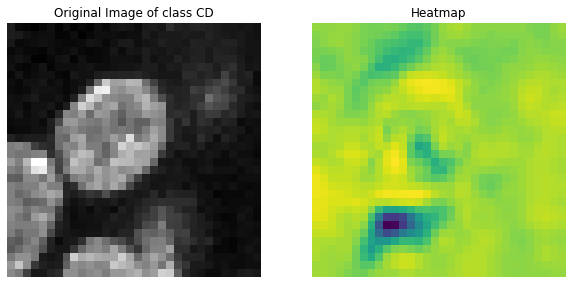

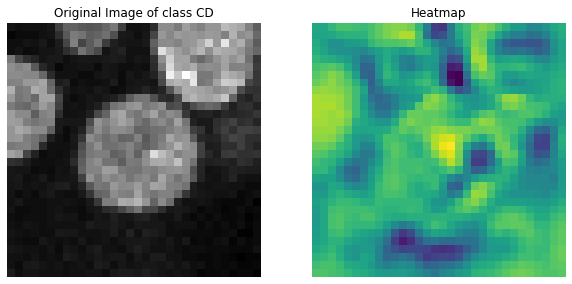

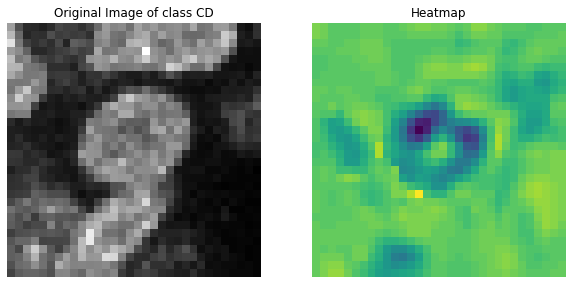

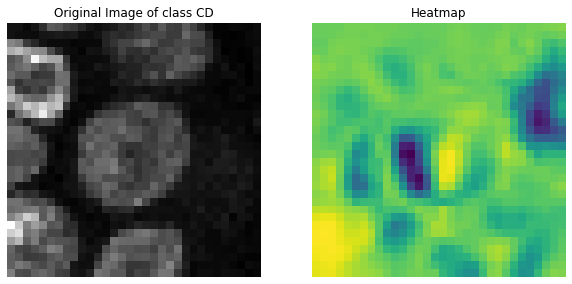

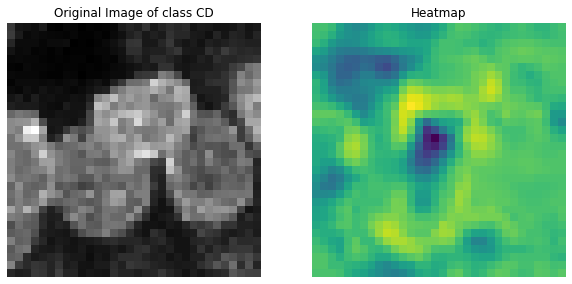

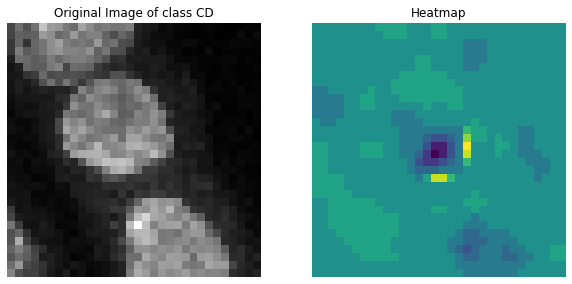

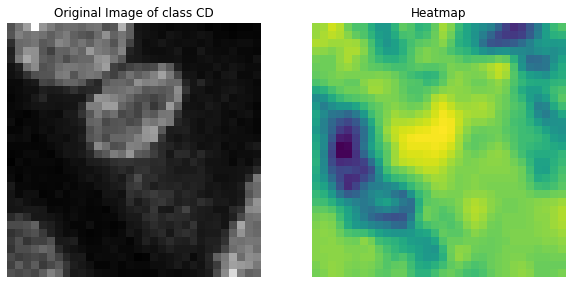

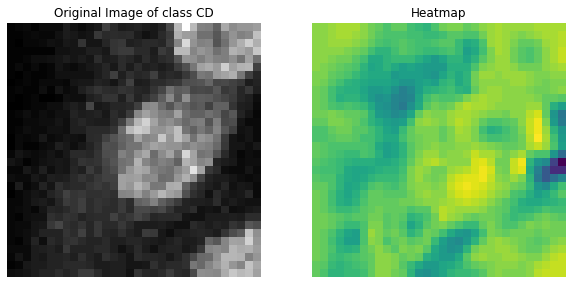

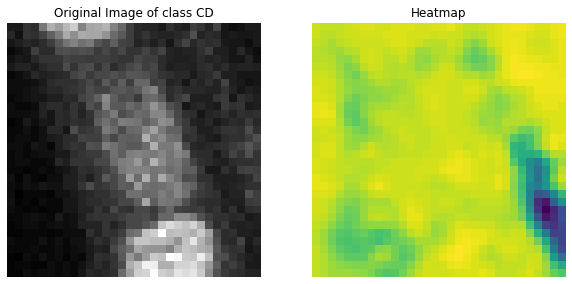

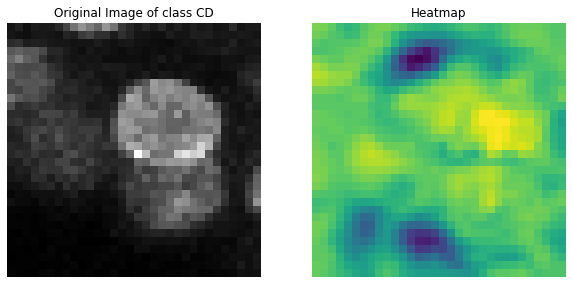

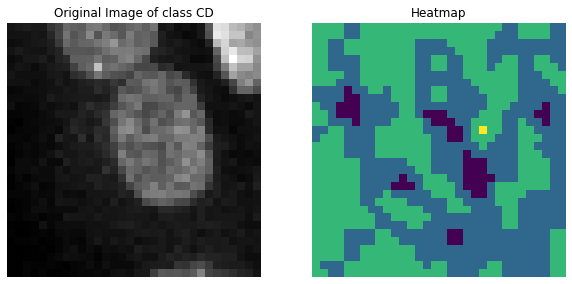

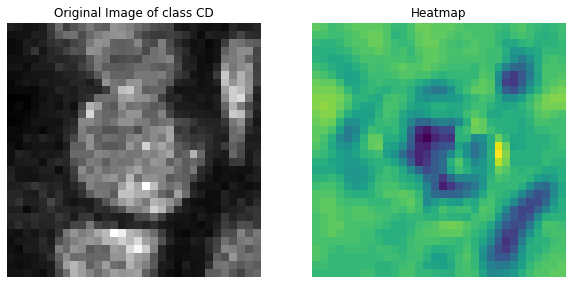

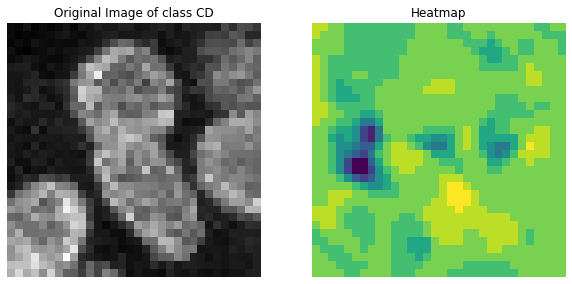

In [47]:
i = 0
hms = []
while i < 15:
    data, label = next(iter(data_loader))
    lab = classes[int(np.squeeze(label.numpy()))]
    
    softmax = model(data.cuda())
    prediction = np.argmax(softmax.detach().cpu().numpy())
    true_class = int(np.squeeze(label.numpy()))
    if true_class != 4 or prediction != true_class:
        continue
    i += 1
    hm = make_heatmap(data.cuda(), true_class, k=3, stride=2)
    hms.append(hm)
    
hms = np.array(hms)
print(hms.shape)


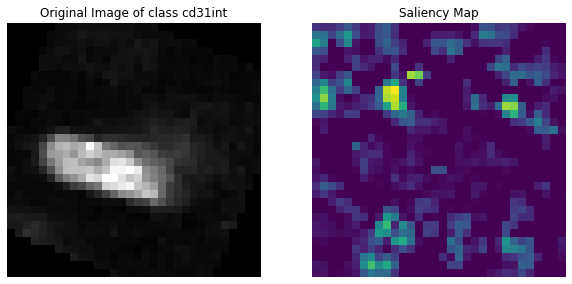

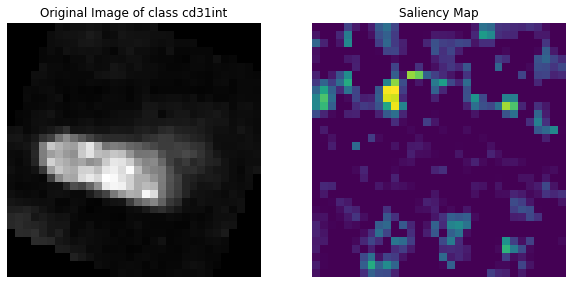

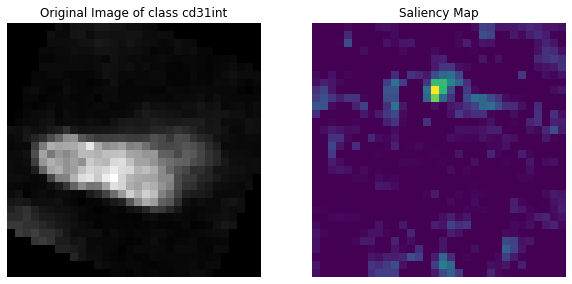

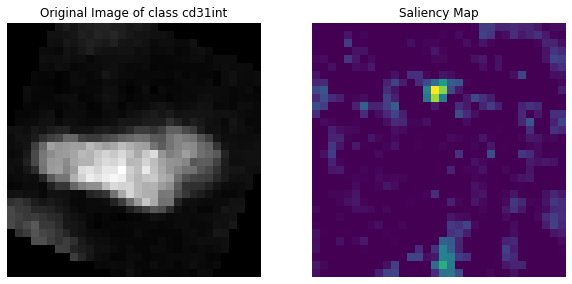

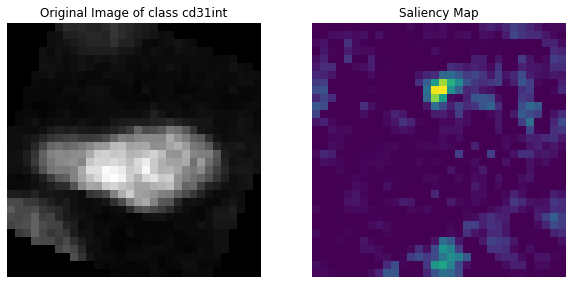

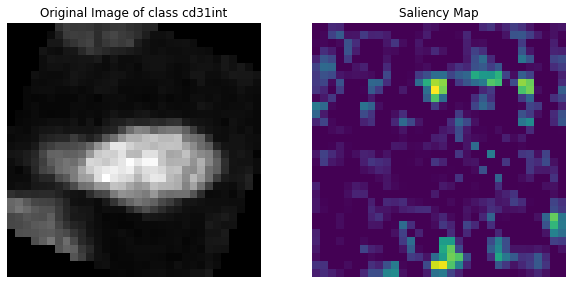

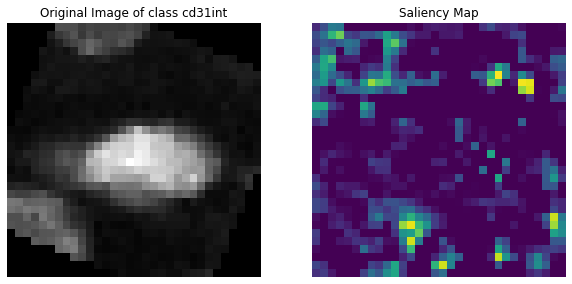

In [27]:
def make_saliency_map(input, label, idx2plot=3):
    input = Variable(input.cuda(), requires_grad=True)
    output = model.forward(input)
    output[0][label].backward()
    grads = input.grad.data.clamp(min=0)
    grads.squeeze_()
    #grads = np.amax(grads.cpu().numpy(), axis=0)
    grads = grads.detach().cpu().numpy()
    
    true_image = input.data
    true_image = true_image.squeeze()
    true_image = true_image*torch.Tensor([data_loader.stdev]).cuda() + torch.Tensor([data_loader.mean]).cuda()
    true_image = true_image.detach().cpu().numpy()

    fig = plt.figure(figsize=(10,10))
    #plt.rcParams["figure.figsize"] = (20, 20)

    a = fig.add_subplot(1,2,1)
    imgplot = plt.imshow(true_image[idx2plot], cmap = 'gray')
    plt.title('Original Image of class {}'.format(classes[int(np.squeeze(label))]))
    plt.axis('off') 

    a = fig.add_subplot(1,2,2)
    imgplot = plt.imshow(grads[idx2plot])
    plt.axis('off') 
    plt.title('Saliency Map')
    
    return grads

data, label = next(iter(data_loader))
lab = classes[int(np.squeeze(label.numpy()))]
true_class = int(np.squeeze(label.numpy()))
for i in range(7):
    grads = make_saliency_map(data.cuda(), true_class, idx2plot = i)

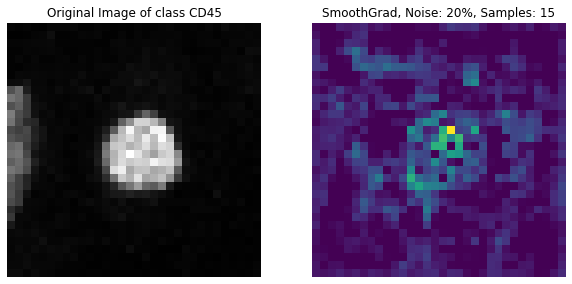

In [53]:
def smooth_grad(input, label, x=10, percent_noise=10, idx2plot = 2):
    """
    The apparent noise one sees in a sensitivity map may be due to 
    essentially meaningless local variations in partial derivatives.
    After all, given typical training techniques there is no reason to expect derivatives to vary smoothly.
    """
    tensor_input = data.cuda()
    # x is the sample size
    final_grad = torch.zeros((1,1,7,32,32)).cuda()
    for i in range(x):
        #print('Sample:', i+1)
        temp_input = Variable(input.cuda(), requires_grad=True)
        # According to the paper, noise level corrresponds to stddev/(xmax-xmin). Hence stddev = noise_percentage * (max-min) /100
        noise = torch.from_numpy(np.random.normal(loc=0, scale=(percent_noise/100) * (tensor_input.cpu().max() - tensor_input.cpu().min()),
                                                  size=temp_input.shape)).type(torch.cuda.FloatTensor)
        temp_input = (temp_input + noise)
        temp_input = Variable(temp_input.cuda(), requires_grad=True)

        output = model.forward(temp_input)
        output[0][label].backward()
        final_grad += temp_input.grad.data
    
    grads = final_grad/x
    grads = grads.clamp(min=0)
    grads.squeeze_()
    #grads = np.amax(grads.cpu().numpy(), axis=0)
    grads = grads.detach().cpu().numpy()
    
    true_image = input.cuda()
    true_image = true_image.squeeze()
    true_image = true_image*torch.Tensor([data_loader.stdev]).cuda() + torch.Tensor([data_loader.mean]).cuda()
    true_image = true_image.detach().cpu().numpy()

    fig = plt.figure(figsize = (10,10))
    #plt.rcParams["figure.figsize"] = (10, 10)

    #plot max projection only
    true_image = np.max(true_image, axis = 0)
    grads = np.max(grads, axis = 0)
    
    a = fig.add_subplot(1,2,1)
    #imgplot = plt.imshow(true_image[idx2plot], cmap = 'gray')
    imgplot = plt.imshow(true_image, cmap = 'gray')
    plt.title('Original Image of class {}'.format(lab))
    plt.axis('off') 

    a = fig.add_subplot(1,2,2)
    imgplot = plt.imshow(grads)
    #imgplot = plt.imshow(grads[idx2plot])
    plt.axis('off')  
    plt.title('SmoothGrad, Noise: ' + str(percent_noise) + '%, ' + 'Samples: ' + str(x))
    
    return grads

data, label = next(iter(data_loader))
lab = classes[int(np.squeeze(label.numpy()))]
true_class = int(np.squeeze(label.numpy()))
grads = smooth_grad(data, true_class, x=15, percent_noise=20, idx2plot = i)
for i in range(7):
    a=i
    #grads = smooth_grad(data, true_class, x=15, percent_noise=20, idx2plot = i)

In [ ]:
#========================================================#